<a href="https://colab.research.google.com/github/BaiyUdng/Big-Data-Project-Regression/blob/master/%E6%8F%90%E5%8F%96%E5%9B%BE%E5%83%8F%E7%89%B9%E5%BE%81%EF%BC%88RGB%E3%80%81%E7%BA%B9%E7%90%86%E3%80%81%E5%9B%BE%E5%83%8F%E7%86%B5%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.提前将羽流原始图片和模型各打包成zip，放进one drive。接着挂载one drive，只需运行即可

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/path/to/data.zip /content

Mounted at /content/gdrive
cp: cannot stat '/content/gdrive/MyDrive/path/to/data.zip': No such file or directory


2.解压我们的plume-image.zip，将羽流原始文件解压出来

In [16]:
# Unzip images to a custom data folder
!unzip -q /content/plume-image.zip -d /content/custom_data

replace /content/custom_data/images_raw/020723_Deep-Sea-Mining-Effect-on-Oceans_01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

3.解压我们的模型my_model.zip，将yolo模型文件解压出来

In [17]:
# Unzip images to a custom data folder
!unzip -q /content/my_model.zip -d /content/custom_data

replace /content/custom_data/my_model.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

4.下载yolo

In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

5.安装所需代码

In [5]:
!pip install -U scikit-image

6.下载完成YOLO后，开始用我们的模型检测羽流原始图像。检测完成后开始跑特征提取代码

In [6]:
from pathlib import Path
from ultralytics import YOLO
import cv2
import pandas as pd
import numpy as np
from skimage.feature import graycomatrix, graycoprops
# from skimage.color import rgb2gray  # cv2效率更高，这个可以不用了
# from skimage.util import img_as_ubyte # cv2直接生成uint8，这个也不需要了
from scipy.stats import entropy
from scipy.stats import skew, kurtosis

# ✅ 定义一个完整的特征提取函数
def extract_all_features(roi):
    """
    从一个图像区域(ROI)中提取所有颜色和纹理特征。
    """
    features = {}

    # --- 1. 颜色空间转换与特征提取 ---
    # 检查ROI是否有效
    if roi.size == 0:
        return None

    # 将图像从OpenCV的BGR格式转换为其他颜色空间
    try:
        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
    except cv2.error:
        print("Warning: Could not convert color space. ROI might be too small or invalid.")
        return None

    # 存储所有待分析的通道
    color_spaces = {
        'R': roi[:, :, 2], 'G': roi[:, :, 1], 'B': roi[:, :, 0], # OpenCV读入是BGR顺序
        'H': hsv[:, :, 0], 'S': hsv[:, :, 1], 'V': hsv[:, :, 2],
        'L': lab[:, :, 0], 'a': lab[:, :, 1], 'b': lab[:, :, 2],
    }

    # 提取颜色统计特征（均值, 标准差, 偏度, 峰度）
    for name, channel in color_spaces.items():
        flat_channel = channel.flatten()
        if flat_channel.size > 0:
            features[f'{name}_mean'] = np.mean(flat_channel)
            features[f'{name}_std'] = np.std(flat_channel)
            features[f'{name}_skew'] = skew(flat_channel)
            features[f'{name}_kurtosis'] = kurtosis(flat_channel)
        else: # 如果通道为空，则赋默认值
            features[f'{name}_mean'] = 0
            features[f'{name}_std'] = 0
            features[f'{name}_skew'] = 0
            features[f'{name}_kurtosis'] = 0


    # --- 2. 灰度图纹理特征提取 ---
    # 修正：统一使用cv2进行灰度图转换，效率更高且直接输出后续步骤所需的uint8格式
    gray_u8 = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # 图像熵
    histogram, _ = np.histogram(gray_u8, bins=256, range=(0, 256))
    prob_dist = histogram / np.sum(histogram)
    # 避免 log(0)
    prob_dist = prob_dist[prob_dist > 0]
    features['entropy'] = entropy(prob_dist)

    # GLCM纹理特征
    # 检查灰度图像是否为空或所有像素值都相同
    if gray_u8.size == 0 or np.all(gray_u8 == gray_u8[0, 0]):
        features['contrast'] = 0
        features['homogeneity'] = 1
        features['energy'] = 1 # 纯色图像能量为1
        features['correlation'] = 1 # 纯色图像相关性为1
    else:
        # skimage.feature.graycomatrix 需要的灰度级别数不能为0
        levels = np.max(gray_u8) + 1
        if levels > 1:
            glcm = graycomatrix(gray_u8, distances=[1], angles=[0], levels=levels, symmetric=True, normed=True)
            features['contrast'] = graycoprops(glcm, 'contrast')[0, 0]
            features['homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
            features['energy'] = graycoprops(glcm, 'energy')[0, 0]
            features['correlation'] = graycoprops(glcm, 'correlation')[0, 0]
        else: # 如果灰度级别只有1级（即纯色），赋默认值
            features['contrast'] = 0
            features['homogeneity'] = 1
            features['energy'] = 1
            features['correlation'] = 1

    return features

# --- 主程序部分 (您的这部分逻辑非常清晰，基本无需改动) ---

# ✅ 加载模型
model = YOLO('/content/custom_data/my_model.pt')

# ✅ 图像路径
img_dir = Path("/content/custom_data/images_raw")
output_data = []

# ✅ 图像检测 + 特征提取
print("Starting feature extraction...")
for img_path in img_dir.glob("*.jpg"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Warning: Could not read image {img_path}. Skipping.")
        continue

    results_list = model(img)

    # 检查是否有检测结果
    if results_list and results_list[0].boxes:
        boxes = results_list[0].boxes.xyxy.cpu().numpy()

        # 如果一张图有多个羽流，可以选择只处理最大的那个，或者都处理
        # 这里我们选择都处理
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box[:4])

            # 确保边界框坐标有效
            if x1 >= 0 and y1 >= 0 and x2 <= img.shape[1] and y2 <= img.shape[0] and x2 > x1 and y2 > y1:
                roi = img[y1:y2, x1:x2]

                features = extract_all_features(roi)

                if features:
                    features["filename"] = f"{img_path.stem}_box{i+1}.jpg" # 添加一个唯一的标识符
                    features["box_x1"] = x1
                    features["box_y1"] = y1
                    features["box_x2"] = x2
                    features["box_y2"] = y2
                    output_data.append(features)
            else:
                print(f"Warning: Invalid box coordinates for image {img_path}: {box}. Skipping.")
    else:
        print(f"No objects detected in image {img_path}.")

# ✅ 保存为CSV
if output_data:
    df = pd.DataFrame(output_data)
    df.to_csv("plume_features.csv", index=False)
    print("\nFeature extraction complete!")
    print(f"Features from {len(df)} detected plumes have been saved to plume_features.csv")
else:
    print("\nNo features were extracted.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Starting feature extraction...

0: 384x640 1 plume, 571.7ms
Speed: 18.2ms preprocess, 571.7ms inference, 29.1ms postprocess per image at shape (1, 3, 384, 640)



/tmp/ipython-input-6-3374003016.py:74: RuntimeWarning: overflow encountered in scalar add
  levels = np.max(gray_u8) + 1


0: 384x640 1 plume, 495.2ms
Speed: 4.3ms preprocess, 495.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plume, 543.7ms
Speed: 4.5ms preprocess, 543.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plume, 527.2ms
Speed: 4.8ms preprocess, 527.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plume, 538.0ms
Speed: 5.0ms preprocess, 538.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plume, 332.8ms
Speed: 4.3ms preprocess, 332.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plume, 342.4ms
Speed: 4.1ms preprocess, 342.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plume, 346.6ms
Speed: 4.1ms preprocess, 346.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plume, 347.1ms
Speed: 4.1ms preprocess, 347.1ms inference, 1.0ms postprocess per image at shape (1

7.将上一步完成的plume_features.csv拉到colab中，把我们对应的concentration_labels.csv文件也拉到colab中。开始训练回归模型。
注意：concentration_labels.csv文件是要自己做的。一列是视频名称，一列是浓度

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import numpy as np

# --- 1. 加载并合并数据 ---
# 请确保您已经将这两个文件上传到了Colab
try:
    features_df = pd.read_csv('plume_features-gemini.csv')
    labels_df = pd.read_csv('concentration_labels.csv')

    # 关键步骤：合并两个DataFrame
    # 我们假设 concentration_labels.csv 文件中有一个 'filename' 列与特征文件对应
    # 注意：为了匹配，我们可能需要去掉特征文件中添加的 '_box1' 后缀
    features_df['base_filename'] = features_df['filename'].apply(lambda x: x.split('_box')[0] + '.jpg')

    # 假设标签文件的列名是 'filename' 和 'concentration'
    # 如果您的列名不同，请在此处修改
    merged_df = pd.merge(features_df, labels_df, left_on='base_filename', right_on='filename', how='inner')

    # 删除用于合并的辅助列和多余的文件名列
    merged_df = merged_df.drop(columns=['base_filename', 'filename_y'])
    merged_df = merged_df.rename(columns={'filename_x': 'filename'})

    print(f"数据合并成功！共找到 {len(merged_df)} 条带有浓度标签的样本。")
    print("合并后数据预览：")
    print(merged_df.head())

except FileNotFoundError:
    print("错误：请确保 'plume_features-gemini.csv' 和 'concentration_labels.csv' 文件已上传到Colab。")
    # 如果报错，请停止执行
    exit()
except KeyError as e:
    print(f"错误：列名不存在 - {e}。请检查您的CSV文件，确保'filename'和'concentration'列名正确。")
    exit()


# --- 2. 准备训练数据 ---
# 特征 (X) 是除了文件名和浓度之外的所有列
features = merged_df.drop(columns=['filename', 'concentration'])
# 目标 (y) 是浓度列
target = merged_df['concentration']

# 将数据划分为训练集（80%）和测试集（20%）
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f"\n数据已划分为：{len(X_train)} 条训练样本 和 {len(X_test)} 条测试样本。")


# --- 3. 训练随机森林回归模型 ---
print("\n开始训练随机森林回归模型...")
# n_estimators=100 表示模型由100棵决策树组成，是一个常用的默认值
# random_state=42 确保每次运行结果都一样，便于复现
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("模型训练完成！")


# --- 4. 在测试集上评估模型性能 ---
print("\n正在测试集上评估模型...")
predictions = model.predict(X_test)

# 计算评估指标
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"模型评估结果：")
print(f"  - 平均绝对误差 (MAE): {mae:.4f}")
print(f"  - 均方误差 (MSE): {mse:.4f}")
print(f"  - R² 分数 (决定系数): {r2:.4f}")

if r2 > 0.8:
    print("\n祝贺您！R²分数非常高，表明您的模型预测效果很好！")
elif r2 > 0.6:
    print("\n模型效果不错。R²分数良好，具有一定的预测能力。")
else:
    print("\n模型效果一般。R²分数较低，可能需要更多数据或调整特征。")


# 5. 分析特征重要性
print("\n计算特征重要性...")
importances = model.feature_importances_
feature_names_in_order = features.columns.tolist() # <--- 获取正确的特征顺序
feature_importance_df = pd.DataFrame({
    'feature': feature_names_in_order, # <--- 使用这个确保顺序一致
    'importance': importances
}).sort_values('importance', ascending=False)

print("对预测浓度最重要的10个图像特征是：")
print(feature_importance_df.head(10))


# --- 6. 保存训练好的模型和特征列表 (这是修改的关键！) ---
model_filename = 'plume_concentration_model.joblib'
joblib.dump(model, model_filename)
print(f"\n训练好的模型已保存为 '{model_filename}'")

# 新增下面这行代码！
feature_list_filename = 'feature_names.joblib'
joblib.dump(feature_names_in_order, feature_list_filename)
print(f"特征顺序列表已保存为 '{feature_list_filename}'")


数据合并成功！共找到 144 条带有浓度标签的样本。
合并后数据预览：
       R_mean      R_std    R_skew  R_kurtosis      G_mean      G_std  \
0  147.777503  35.152172 -0.159791   -0.410145  147.945777  32.928958   
1  135.844928  42.196808 -0.179408   -1.189043  133.220985  42.668759   
2  225.229787  18.484728 -0.727673    0.060395  226.208287  17.564930   
3  204.917900  25.188087 -0.546571   -0.770958  214.723278  25.479342   
4  135.597461  31.461213 -0.707731   -0.163887  137.826522  28.995311   

     G_skew  G_kurtosis      B_mean      B_std  ...  contrast  homogeneity  \
0 -0.205246   -0.442527  123.923981  32.171363  ...  0.000000     1.000000   
1 -0.266913   -1.091634  124.121079  54.438742  ...  1.085968     0.878233   
2 -0.851492    0.190993  164.651624  19.123808  ...  0.639960     0.880089   
3 -0.585855   -1.005376  172.328175  24.365978  ...  1.555850     0.690069   
4 -0.843333   -0.048566  132.080996  38.940686  ...  2.196557     0.680464   

     energy  correlation                                

模型测试，安装相关库

In [8]:
pip install ultralytics opencv-python scikit-image joblib

然后运行脚本

正在加载模型...
模型和特征列表加载成功！

0: 384x640 1 plume, 350.5ms
Speed: 2.5ms preprocess, 350.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
处理完成，显示结果：


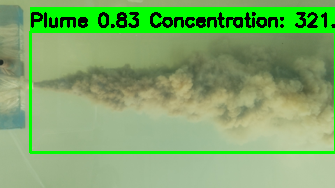

In [14]:
import cv2
import joblib
import pandas as pd
import numpy as np
from pathlib import Path
from ultralytics import YOLO
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy, skew, kurtosis
# 在Colab中，我们需要这个库来显示图片
from google.colab.patches import cv2_imshow

# ==============================================================================
#  1. 特征提取函数 (这是你之前编写的函数，我们直接复用)
# ==============================================================================
def extract_all_features(roi):
    """
    从一个图像区域(ROI)中提取所有颜色和纹理特征。
    """
    features = {}

    # 检查ROI是否有效
    if roi.size == 0:
        return None

    # --- 颜色空间转换与特征提取 ---
    try:
        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
    except cv2.error:
        print("Warning: Could not convert color space. ROI might be too small or invalid.")
        return None

    color_spaces = {
        'R': roi[:, :, 2], 'G': roi[:, :, 1], 'B': roi[:, :, 0],
        'H': hsv[:, :, 0], 'S': hsv[:, :, 1], 'V': hsv[:, :, 2],
        'L': lab[:, :, 0], 'a': lab[:, :, 1], 'b': lab[:, :, 2],
    }

    for name, channel in color_spaces.items():
        flat_channel = channel.flatten()
        if flat_channel.size > 0:
            features[f'{name}_mean'] = np.mean(flat_channel)
            features[f'{name}_std'] = np.std(flat_channel)
            features[f'{name}_skew'] = skew(flat_channel)
            features[f'{name}_kurtosis'] = kurtosis(flat_channel)
        else:
            features.update({f'{name}_mean': 0, f'{name}_std': 0, f'{name}_skew': 0, f'{name}_kurtosis': 0})

    # --- 灰度图纹理特征提取 ---
    gray_u8 = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    histogram, _ = np.histogram(gray_u8, bins=256, range=(0, 256))
    prob_dist = histogram / np.sum(histogram)
    prob_dist = prob_dist[prob_dist > 0]
    features['entropy'] = entropy(prob_dist)

    if gray_u8.size == 0 or np.all(gray_u8 == gray_u8[0, 0]):
        features.update({'contrast': 0, 'homogeneity': 1, 'energy': 1, 'correlation': 1})
    else:
        levels = np.max(gray_u8) + 1
        if levels > 1:
            glcm = graycomatrix(gray_u8, distances=[1], angles=[0], levels=levels, symmetric=True, normed=True)
            features['contrast'] = graycoprops(glcm, 'contrast')[0, 0]
            features['homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
            features['energy'] = graycoprops(glcm, 'energy')[0, 0]
            features['correlation'] = graycoprops(glcm, 'correlation')[0, 0]
        else:
            features.update({'contrast': 0, 'homogeneity': 1, 'energy': 1, 'correlation': 1})

    return features

# ... (前面的代码，包括 extract_all_features 函数保持不变) ...

# ==============================================================================
#  2. 加载训练好的模型 (这是修改的关键！)
# ==============================================================================
print("正在加载模型...")
try:
    # 加载YOLOv8模型用于目标检测
    detection_model = YOLO('/content/custom_data/my_model.pt')

    # 加载随机森林模型用于浓度回归
    regression_model = joblib.load('/content/custom_data/plume_concentration_model.joblib')

    # 关键修改：不再手动定义列表，而是从文件中加载！
    feature_columns = joblib.load('/content/custom_data/feature_names.joblib')

    print("模型和特征列表加载成功！")
except FileNotFoundError as e:
    print(f"错误：模型或特征列表文件未找到 - {e}。请确保已运行修改后的训练代码。")
    exit()

# ==============================================================================
#  3. 定义主处理函数 (这里的代码完全不需要修改)
# ==============================================================================
def predict_and_display(image_path, conf_threshold=0.5):
    """
    对单张图片进行羽流检测、浓度预测，并以指定格式显示结果。
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"错误：无法读取图片 {image_path}")
        return

    # 使用YOLO模型进行检测
    results = detection_model(img, conf=conf_threshold)

    # 检查是否有检测结果
    if results and results[0].boxes:
        # 从结果中提取边界框和置信度
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confidences = results[0].boxes.conf.cpu().numpy()

        # 使用索引遍历每一个检测到的物体
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box[:4])

            # 裁剪出羽流区域 (ROI)
            roi = img[y1:y2, x1:x2]

            # 提取该区域的特征
            features = extract_all_features(roi)

            if features:
                # 准备数据用于预测
                features.update({'box_x1': x1, 'box_y1': y1, 'box_x2': x2, 'box_y2': y2})
                inference_df = pd.DataFrame([features])
                inference_df = inference_df[feature_columns]

                # 进行浓度预测
                predicted_concentration = regression_model.predict(inference_df)[0]

                # ==========================================================
                # --- 在图片上绘制结果 (这是本次修改的核心区域) ---
                # ==========================================================

                # 1. 获取当前框的置信度
                confidence_score = confidences[i]

                # 2. 按照你要求的格式创建文本标签
                #    单位是mg/L，但我们按要求在显示时不写出单位
                label = f"Plume {confidence_score:.2f} Concentration: {predicted_concentration:.2f}"

                # 3. 设置绘制参数 (颜色等可以按需修改)
                box_color = (0, 255, 0)  # 绿色边界框
                text_color = (0, 0, 0)    # 黑色文字
                bg_color = (0, 255, 0)   # 绿色文字背景
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.6
                thickness = 2

                # 4. 绘制边界框
                cv2.rectangle(img, (x1, y1), (x2, y2), box_color, thickness)

                # 5. 计算文本框大小，并绘制背景
                (w, h), _ = cv2.getTextSize(label, font, font_scale, thickness)
                cv2.rectangle(img, (x1, y1 - (h + 10)), (x1 + w, y1), bg_color, -1)

                # 6. 绘制文本
                cv2.putText(img, label, (x1, y1 - 5), font, font_scale, text_color, thickness)
                # ==========================================================
                # --- 修改结束 ---
                # ==========================================================


    # 在Colab中显示最终的图像
    print("处理完成，显示结果：")
    cv2_imshow(img)

# ==============================================================================
#  4. 执行预测 (这里的代码完全不需要修改)
# ==============================================================================
test_image_path = '/content/custom_data/test_image.jpg' # <--- 请在这里修改为你的图片路径
predict_and_display(test_image_path)
